Data analysis for the Franck-Hertz experiment

/tmp/ipykernel_1715/3767870787.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)
/tmp/ipykernel_1715/3767870787.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)
/tmp/ipykernel_1715/3767870787.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)
/tmp/ipykernel_1715/3767870787.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)
/tmp/ipykernel_1715/3767870787.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)
/tmp/ipykernel_1715/3767870787.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.cur

[array([18.65326648,  0.15086207]),
 array([18.24120618,  0.19559229]),
 array([17.60804033,  0.26255708]),
 array([17.63819109,  0.27635328]),
 array([17.19598002,  0.33021625]),
 array([17.07537702,  0.35609182]),
 array([16.95477401,  0.37640782]),
 array([16.65326647,  0.41943271]),
 array([16.16080415,  0.47885572])]

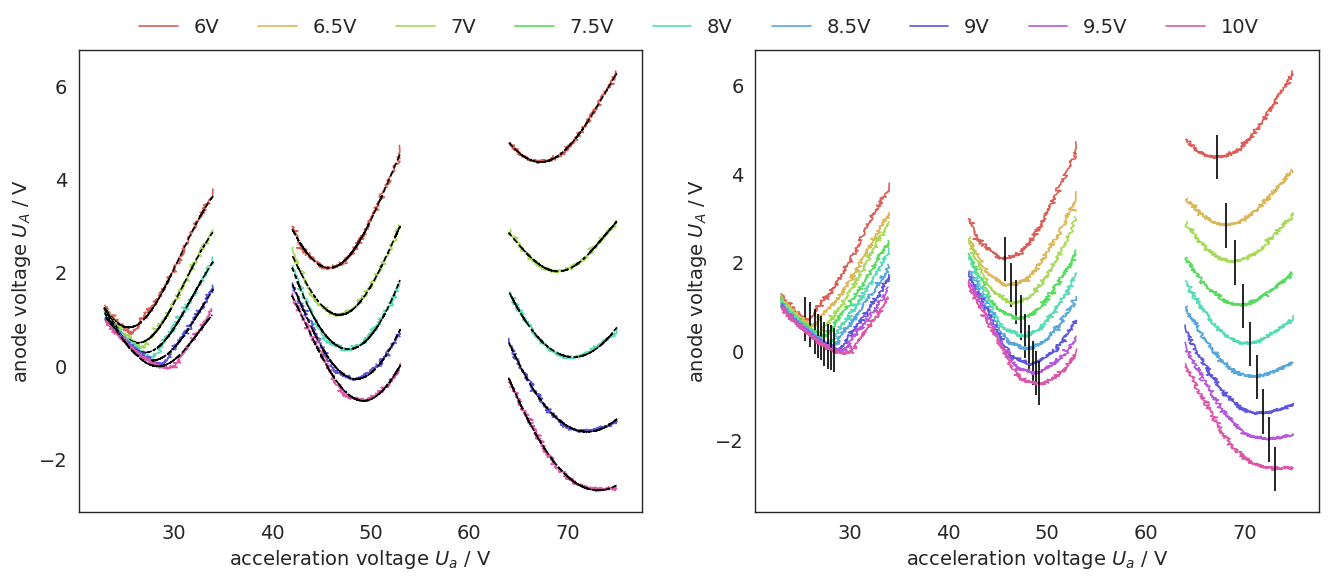

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from uncertainties import *
import matplotlib.pyplot as plt


avgs = pd.DataFrame()
volts = [6, 65, 7, 75, 8, 85, 9, 95, 10]
plt.figure(figsize = (16,6))
E_lam_res = list()
sns.set_style("white")
sns.set_context("paper")

for m_i, m in enumerate(volts):

    # read all 5 iterations of the same measurement
    datas_1 = pd.DataFrame(); datas_2 = pd.DataFrame()
    for i in range(0, 5):
        # for channel 1
        data = pd.read_csv(str("data/scov" + str(m) + "_0" + str(i+1) + ".csv"), skiprows = [1])
        datas_1.insert(0, str(i), data["1"])
        datas_2.insert(0, str(i), data["2"])

    # compute mean and sd of the measurements
    res_1 = pd.concat([datas_1.mean(axis = 1), datas_1.std(axis = 1)], axis = 1)
    res_2 = pd.concat([datas_2.mean(axis = 1), datas_2.std(axis = 1)], axis = 1)
    res_m = res_1.join(res_2, lsuffix = "_2")
    res_m.columns = ["mean_1", "sd_1", "mean_2", "sd_2"]
    # create label with decimal point
    if "5" in str(m):
        m_lab = str(str(m)[0] + "." + str(m)[1] + "V")
    else:
        m_lab = str(str(m) + "V")
    res_m.insert(0, "finvolt", m_lab)
    res_m.insert(0, "time", data["x-axis"])
    # drop last voltage dropoff of data
    res_m = res_m.head(-115)
    
    # combine to one large df for plotting
    if avgs.empty:
        avgs = res_m
    else:
        avgs = pd.concat([avgs, res_m], axis = 0, ignore_index = True)

    # fit minima of channel 1 for three intervalls
    intervals = {"1": [23, 34], "2": [42, 53], "3": [64, 75]} # chosen visually from plot
    minima = np.zeros(3)
    for ind, i in enumerate(intervals.keys()):
        # only take data in interval as input
        input = res_m[(res_m["mean_2"] >= intervals[i][0]) & (res_m["mean_2"] <= intervals[i][1])]
        input = input.reset_index(drop = True) # reset row indices

        # fit minima of interval

        # gaussian minimum offset by grid voltage (not working as well)
        #def fit_fun(p, a, b, mu, sd): return(a*p**(3/2) -b*np.exp(-(p-mu)**2 / (2*sd**2)))
        #ubnd = abs(np.min(input["mean_1"]) / np.min(input["mean_2"]))
        #ps = [ubnd, 2, np.mean([input["mean_2"]]), np.mean([input["mean_2"]])/2]
        #bnds = ([0.7*ubnd,1,0,0], [1.3*ubnd,1000,1000,1000])

        # gaussian minimum with general offset
        def fit_fun(p, a, b, mu, sd): return(a -b*np.exp(-(p-mu)**2 / (2*sd**2)))
        ps = [0, 1, np.mean([input["mean_2"]]), np.mean([input["mean_2"]])/2]
        bnds = (0, 100)
        
        popt, covmat = sp.optimize.curve_fit(fit_fun, input["mean_2"], input["mean_1"], p0 = ps, bounds = bnds)
        y_est = fit_fun(input["mean_2"], popt[0], popt[1], popt[2], popt[3])

        residuals = input["mean_1"] - fit_fun(input["mean_2"], *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((input["mean_1"]-np.mean(input["mean_1"]))**2)
        r_squared = 1 - (ss_res / ss_tot)
        #print(m, i, "Rsq", r_squared)

        if ind == 0 :
            dlab = m_lab
        else:
            dlab = None
        if (m_i % 2) == 0:
            # example plot for fit
            plt.subplot(121)
            plt.plot(input["mean_2"], input["mean_1"], color = sns.color_palette("hls", 9)[m_i], label = dlab)
            plt.plot(input["mean_2"], y_est, c ="black", ls = "--")

        # plot of fit estimates
        plt.subplot(122)
        plt.plot(input["mean_2"], input["mean_1"], color = sns.color_palette("hls", 9)[m_i], label = dlab)

        # find estimated minimum and add to array
        loc = np.where(y_est == np.min(y_est))[0]
        min_pos = input.iloc[loc[0]]["mean_2"]
        minima[ind] = min_pos
        plt.vlines(min_pos, input.iloc[loc[0]]["mean_1"]+0.5, input.iloc[loc[0]]["mean_1"]-0.5, color = "black")

    # compute distances between minima
    min_d = np.diff(minima)
    d_min_d = np.diff(min_d)[0]
    L = 5 # mm from manual
    def fit_dist(n, E, lam): return(E*(1 + (lam/L)*(2*n-1))) # E in e, lam in mm
    popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)
    E_lam_res.append(popt)
# for minima plot
plt.subplot(121)
plt.xlabel("acceleration voltage $U_a$ / V", fontsize=14)
plt.ylabel("anode voltage $U_A$ / V", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(122)
plt.xlabel("acceleration voltage $U_a$ / V", fontsize=14)
plt.ylabel("anode voltage $U_A$ / V", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc = 'center', bbox_to_anchor = (-0.1, 1.05), ncol = len(volts), frameon = False, prop={'size': 14})
plt.savefig("min_estimation.png", dpi=400)
E_lam_res

In [2]:
energies = np.zeros(len(E_lam_res))
i=0
for e_lam in E_lam_res:
    energies[i] = e_lam[0]
    i +=1
print(energies)

[18.65326648 18.24120618 17.60804033 17.63819109 17.19598002 17.07537702
 16.95477401 16.65326647 16.16080415]


In [3]:
print(energies.mean(),energies.std())

17.353433971777786 0.7300877154271056


In [4]:
lambdas = np.zeros(len(E_lam_res))
i=0
for e_lam in E_lam_res:
    lambdas[i] = e_lam[1]
    i +=1
print(lambdas)

[0.15086207 0.19559229 0.26255708 0.27635328 0.33021625 0.35609182
 0.37640782 0.41943271 0.47885572]


In [5]:
print(lambdas.mean(), lambdas.std())

0.31626322575344123 0.09937292882897207


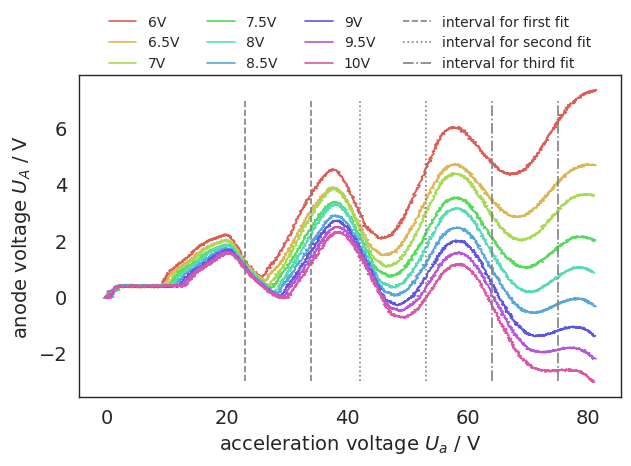

In [6]:
# plot all curves plus decided fit range in t
vals = avgs["finvolt"].unique()
for i in range(len(vals)):
    subset = avgs[avgs["finvolt"] == vals[i]]
    plt.plot(subset["mean_2"], subset["mean_1"], color = sns.color_palette("hls", 9)[i], label = vals[i])

plt.vlines(intervals["1"], -3, 7, color = "grey", ls = "--", label = "interval for first fit")
plt.vlines(intervals["2"], -3, 7, color = "grey", ls = ":", label = "interval for second fit")
plt.vlines(intervals["3"], -3, 7, color = "grey", ls = "-.", label = "interval for third fit")
plt.xlabel("acceleration voltage $U_a$ / V", fontsize=14)
plt.ylabel("anode voltage $U_A$ / V", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc = 'center', bbox_to_anchor = (0.5, 1.1), ncol = 4, title = None, frameon = False, prop={'size': 10})
plt.tight_layout()
plt.savefig("interval_choice_plot.png", dpi = 400)
plt.show()

In [7]:
#### post report, trying to implement error calculation

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from uncertainties import ufloat, unumpy, umath
import matplotlib.pyplot as plt


avgs = pd.DataFrame()
volts = [6, 65, 7, 75, 8, 85, 9, 95, 10]
plt.figure(figsize = (16,6))
E_lam_res_propagated = list()
E_lam_res_solved = list()
sns.set_style("white")
sns.set_context("paper")

for m_i, m in enumerate(volts):

    # read all 5 iterations of the same measurement
    datas_1 = pd.DataFrame(); datas_2 = pd.DataFrame()
    for i in range(0, 5):
        # for channel 1
        data = pd.read_csv(str("data/scov" + str(m) + "_0" + str(i+1) + ".csv"), skiprows = [1])
        datas_1.insert(0, str(i), data["1"])
        datas_2.insert(0, str(i), data["2"])

    # compute mean and sd of the measurements
    res_1 = pd.concat([datas_1.mean(axis = 1), datas_1.std(axis = 1)], axis = 1)
    res_2 = pd.concat([datas_2.mean(axis = 1), datas_2.std(axis = 1)], axis = 1)
    res_m = res_1.join(res_2, lsuffix = "_2")
    res_m.columns = ["mean_1", "sd_1", "mean_2", "sd_2"]
    # create label with decimal point
    if "5" in str(m):
        m_lab = str(str(m)[0] + "." + str(m)[1] + "V")
    else:
        m_lab = str(str(m) + "V")
    res_m.insert(0, "finvolt", m_lab)
    res_m.insert(0, "time", data["x-axis"])
    # drop last voltage dropoff of data
    res_m = res_m.head(-115)
    
    # combine to one large df for plotting
    if avgs.empty:
        avgs = res_m
    else:
        avgs = pd.concat([avgs, res_m], axis = 0, ignore_index = True)

    # fit minima of channel 1 for three intervalls
    intervals = {"1": [23, 34], "2": [42, 53], "3": [64, 75]} # chosen visually from plot
    minima = list()
    for ind, i in enumerate(intervals.keys()):
        # only take data in interval as input
        input = res_m[(res_m["mean_2"] >= intervals[i][0]) & (res_m["mean_2"] <= intervals[i][1])]
        input = input.reset_index(drop = True) # reset row indices

        # fit minima of interval

        # gaussian minimum offset by grid voltage (not working as well)
        #def fit_fun(p, a, b, mu, sd): return(a*p**(3/2) -b*np.exp(-(p-mu)**2 / (2*sd**2)))
        #ubnd = abs(np.min(input["mean_1"]) / np.min(input["mean_2"]))
        #ps = [ubnd, 2, np.mean([input["mean_2"]]), np.mean([input["mean_2"]])/2]
        #bnds = ([0.7*ubnd,1,0,0], [1.3*ubnd,1000,1000,1000])

        # gaussian minimum with general offset
        def fit_fun(p, a, b, mu, sd): return(a -b*np.exp(-(p-mu)**2 / (2*sd**2)))
        ps = [0, 1, np.mean([input["mean_2"]]), np.mean([input["mean_2"]])/2]
        bnds = (0, 100)
        
        popt, covmat = sp.optimize.curve_fit(fit_fun, input["mean_2"], input["mean_1"], p0 = ps, bounds = bnds)
        y_est = fit_fun(input["mean_2"], popt[0], popt[1], popt[2], popt[3])

        popt_u = [ufloat(popt[i], np.sqrt(covmat[i,i])) for i in np.arange(len(popt))]
        #print(m_i, ind, ": ", popt_u)
        y_est = popt_u[0] -popt_u[1]*unumpy.exp(-(input["mean_2"]-popt_u[2])**2 / (2*popt_u[3]**2))
        y_est_n = [y_e.n for y_e in y_est]
        # find estimated minimum and add to array
        loc = np.where(y_est_n == np.min(y_est_n))[0]
        min_pos = ufloat(input.iloc[loc[0]]["mean_2"],y_est[loc[0]].s)
   
        minima.append(min_pos)


    # compute distances between minima
    min_d = np.diff(minima)
    L = 5 # mm from manual
    def fit_dist(n, E, lam): return(E*(1 + (lam/L)*(2*n-1))) # E in e, lam in mm
    popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], [m_d.n for m_d in min_d], sigma=[m_d.s for m_d in min_d], absolute_sigma=True)

    #solving system of equations
    n = np.array([2,3])
    min_d = np.array([min_d[0], min_d[1]])
    E_propagated = ( min_d[0] - min_d[1]*((2*n[0]-1)/(2*n[1]-1)) ) / (1 - ((2*n[0]-1)/(2*n[1]-1)))
    lam_propagated = L*(min_d[0]-min_d[1]) / ( min_d[1]*(2*n[0]-1) - min_d[0]*(2*n[1]-1) )
    E_lam_res_propagated.append((E_propagated, np.average(lam_propagated)))


print("previous results:\n", np.array(E_lam_res))
print("propagated results:\n", np.array(E_lam_res_propagated))

previous results:
 [[18.65326648  0.15086207]
 [18.24120618  0.19559229]
 [17.60804033  0.26255708]
 [17.63819109  0.27635328]
 [17.19598002  0.33021625]
 [17.07537702  0.35609182]
 [16.95477401  0.37640782]
 [16.65326647  0.41943271]
 [16.16080415  0.47885572]]
propagated results:
 [[18.653266477000003+/-1.4894627640838118
  0.15086206903599586+/-0.11484523450201974]
 [18.241206179000006+/-1.3888684434679068
  0.19559228594803277+/-0.11035130704333944]
 [17.608040331000012+/-2.267924155168035
  0.26255707836270176+/-0.19535186140170427]
 [17.63819108500001+/-5.544338700002242
  0.276353276904074+/-0.5777946750853682]
 [17.195980022000025+/-917.0242719215146
  0.33021624895674456+/-106.40046071004737]
 [17.07537702300001+/-644.7495375333646
  0.35609181845940296+/-76.37597280938303]
 [16.95477401299999+/-524.0861745869444
  0.37640782354909075+/-63.15225246011741]
 [16.653266467000012+/-16.528564394984436
  0.4194327094231785+/-2.0550542362031723]
 [16.16080414900001+/-23.6379122321837

<Figure size 1600x600 with 0 Axes>

In [10]:
#using absolute sigma
print(popt)
print(np.sqrt(covmat))

[16.16080415  0.47885572]
[[23.61868673         nan]
 [        nan  3.13369806]]


/tmp/ipykernel_1715/878932937.py:2: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(covmat))
